# Project 3 - LING583
## Women's E-Commerce Clothing Reviews 

### Introduction 

E-Commerce has been one of the most successful field nowadays, especially for fashion. Customers would have confidence in the E-commerce fashion companies if they are more likely to get positive reviews. The feedbacks can range from the quality of the outfits, the price of the clothes, how easily ones can navigate through the website to purchase a piece of apparel, how fast the items got delivered, and how identical the clothes look in-person compared to the advertised images. A Women’s Clothing E-Commerce dataset was retrieved from Kaggle.com to address the important of reviews. The data set has 23,500 reviews in English with the highest number of reviews being 5-star ratings and lowest being 1-star ratings. 

### Questions

1. What are the most common terms presented in the reviews?
2. Can we generate topic label for each reviews? 
3. Using a set of training data, can we predict rating bucket for the future reviews? 

### Outline 

Here is a brief table of content for this report:

- Load Memories: load all the modules and functions needed for this report 
- Data Pre-Processing: load the data and process the data to prepare for model development 
  1. Load data and pre-processing 
  2. Guess language of review texts 
  3. Find domain-specific terms 
- Topic models: contruct a list of lables for the reviews  
  1. Tokenize reviews 
  2. Topic model development 
  3. Evaludate the model 
  4. Topic model visualization 
  5. Word cloud 
  6. Save Topics
  7. Add labels 
  8. Find labels for all reviews 
  9. Review labels of all reviews
- Classifier Model to Predict Type of Reviews - Model Selection
  1. Data processing
  2. Train/test split 
  3. Generate baseline dummy classifier 
  4. Bernoulli Naive Bayes Model
  5. Multinomial Naive Bayes
  6. SGD Classifier 
  7. Tfidf Transformer
  8. Truncated SVD
- Hyperparameter Search
  1. Define baseline model 
  2. Generate Optimzied Model
  3. Save model
  4. Improve F1 scores
- Error Analysis
  1. Misclassification 
  2. Confusion matrix 
- Summary of analysis 

Note: See `Final project report.pdf` for a complete report. 

### Load Memories 

Load all modules needed for the entire project. 

In [55]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm
tqdm.pandas()
import time
from collections import Counter, defaultdict
from math import log2
import dask.bag as db
import dask.dataframe as dd
import matplotlib.pyplot as plt  # plot
import pycld2  # langauge guesser
import pyLDAvis  # topic visualization
import spacy  # find terms
import tomotopy as tp  # use tomotopy to built model for topic
from spacy.matcher import Matcher
from tokenizer import MWETokenizer  # tokenizer, import from tokenizer.py
from wordcloud import WordCloud  # word cloud
from sklearn.model_selection import train_test_split # random proportion train/test split 
from sklearn.dummy import DummyClassifier # baseline dummy classifier 
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
import mlflow # hyperparameter search logs
from dask_ml.model_selection import RandomizedSearchCV
from logger import log_search # from file logger.py
from scipy.stats.distributions import loguniform, randint, uniform
from warnings import simplefilter
from scipy import stats
import cloudpickle # save model 

Load all the functions needed for the entire project

In [23]:
# Language Guesser Function
def guess_lang(text):
    try:
        reliable, _, langs = pycld2.detect(text, isPlainText=True, hintLanguage="en")
        if reliable:
            return langs[0][0]
    except pycld2.error as e:
        pass
    return np.NaN


# Function to get terms candidates
def get_candidates(text):
    doc = nlp(text)
    spans = matcher(doc, as_spans=True)
    return [tuple(tok.norm_ for tok in span) for span in spans]


# Function to generate terminology with theta value and counter
def c_value(F, theta):

    termhood = Counter()
    longer = defaultdict(list)

    for k in sorted(F, reverse=True):
        for term in F[k]:
            if term in longer:
                discount = sum(longer[term]) / len(longer[term])
            else:
                discount = 0
            c = log2(k) * (F[k][term] - discount)
            if c > theta:
                termhood[term] = c
                for subterm in get_subterms(term):
                    if subterm in F[len(subterm)]:
                        longer[subterm].append(F[k][term])
    return termhood

### Data Pre-Processing

#### 1. Load data and pre-processing

Load the Women's E-Commerce Clothing Reviews CSV. Then split the data into training and testing data.  

In [24]:
df = pd.read_csv("Womens-Clothing-E-Commerce-Reviews.csv", index_col="ID")

In [25]:
# review first few rows of the dataframe
df.head()

,clothing_id,age,title,review_text,rating,recommended_IND,positive_feedback_count,division_name,department_name,class_name
ID,,,,,,,,,,
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [26]:
# check how many rows the data has
len(df)

23486

Change review texts to type string. 

In [27]:
df["review_text"] = df["review_text"].astype(str)

This data set has a total of 23,486 rows.

#### 2. Guess Language of Review Texts

Add a new column called `lang` to determine the language of each review. Then, select the reviews in English only for consistency.

In [28]:
df["lang"] = df["review_text"].progress_apply(guess_lang)
df = df[df["lang"] == "ENGLISH"].reset_index(drop=True)

  0%|          | 0/23486 [00:00<?, ?it/s]

In [53]:
len(df)

22633

After removing reviews that are not in English, the dataset has 22,633 rows left.

Let's see how many reviews are labeled as good/bad reviews 

In [29]:
df["rating"].value_counts()

5    12535
4     4905
3     2823
2     1549
1      821
Name: rating, dtype: int64

Most of reviews have 5 stars rating; and only 821 of the reviews have 1 stars rating. This women clothing company must have made really good clothes the best quality and price. 

#### 3. Find Domain-Specific Terms

This section will domain-specific terminology (multiword expressions, or MWEs) that is related to all women clothing reviews. 

In [8]:
# use spacy module to load the domain terms
nlp = spacy.load(
    "en_core_web_sm", exclude=["parser", "ner", "lemmatizer", "attribute_ruler"]
)

matcher = Matcher(nlp.vocab)
matcher.add(
    "Term",
    [
        [
            {"TAG": {"IN": ["JJ", "NN", "NNP"]}},
            {"TAG": {"IN": ["JJ", "NN", "IN", "HYPH", "NNP"]}, "OP": "*"},
            {"TAG": {"IN": ["NN", "NNP"]}},
        ]
    ],
)

Use parallelization for tasks to run faster 

In [9]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41885")
client

Client Scheduler: tcp://127.0.0.1:41885 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.62 GB


In [10]:
texts = dd.from_pandas(
    df["review_text"].sample(len(df), random_state=19), npartitions=50
).to_bag()

graph = texts.map(get_candidates).flatten().frequencies()

In [11]:
%%time

candidates = graph.compute()

CPU times: user 4.59 s, sys: 468 ms, total: 5.06 s
Wall time: 57.9 s


In [61]:
from nltk import ngrams


def get_subterms(term):
    k = len(term)
    for m in range(k - 1, 1, -1):
        yield from ngrams(term, m)

In [67]:
freqs = defaultdict(Counter)
for c, f in candidates:
    freqs[len(c)][c] += f

In [68]:
terms = c_value(freqs, theta=50)

In [69]:
for t, c in terms.most_common(20):
    print(f'{c:8.2f} {freqs[len(t)][t]:5d} {" ".join(t)}')

 1756.14  1108 true to size
  474.00   474 usual size
  388.32   245 t - shirt
  293.00   293 regular size
  262.00   262 normal size
  240.00   240 good quality
  236.00   236 high quality
  229.00   229 full price
  217.00   217 little bit
  214.00   214 first time
  207.00   207 great quality
  204.00   204 sale price
  179.00   179 light weight
  176.00   176 body type
  176.00   176 beautiful dress
  159.00   159 petite size
  156.91    99 v - neck
  155.00   155 perfect length
  149.00   149 much fabric
  147.40    93 beautiful in person


Using theta = 50, we are able to see the 20 most related term for the women clothing review. These terms are clearly clothing related terms including terms about size, quality, price, and type of fabric. 

In [70]:
for t, c in tail(20, terms.most_common()):
    print(f'{c:8.2f} {freqs[len(t)][t]:5d} {" ".join(t)}')

   54.00    54 great price
   53.89    34 bit of stretch
   53.89    34 medium in retailer
   53.00    53 perfect dress
   53.00    53 medium weight
   53.00    53 flattering cut
   52.30    33 gorgeous in person
   52.30    33 % off sale
   52.00    52 poor quality
   52.00    52 hourglass shape
   52.00    52 good fit
   52.00    52 elastic waist
   52.00    52 gorgeous dress
   51.08    22 true - to - size
   51.00    51 rib cage
   51.00    51 beautiful sweater
   51.00    51 only problem
   51.00    51 petite small
   51.00    51 other color
   50.72    32 great for summer


The 20 least common terms are terms that don't show up a lot in the reviews. Some terms like "bit of stretch", "medium in retailer", "flattering cut", "hourglass shape", etc. are more specific terms, I can see why they are less common. In addition, terms like "poor quality" and "only problem" are more like negative reviews. Since most reviews are 5-star reviews, I can see why some of the bad review terms would be less common in the review text. 

Although, "great price" would more likely to be a common term, intuitively. But this terms would fall inside the least common term. Let's try changing `theta` to 25, 75, and 100 to see if we can get better terms. 

In [74]:
terms = c_value(freqs, theta=25)

In [75]:
for t, c in terms.most_common(20):
    print(f'{c:8.2f} {freqs[len(t)][t]:5d} {" ".join(t)}')

 1730.78  1108 true to size
  453.00   474 usual size
  388.32   245 t - shirt
  293.00   293 regular size
  262.00   262 normal size
  240.00   240 good quality
  236.00   236 high quality
  217.00   217 little bit
  207.00   207 great quality
  204.00   204 sale price
  202.00   229 full price
  194.00   214 first time
  179.00   179 light weight
  176.00   176 body type
  176.00   176 beautiful dress
  159.00   159 petite size
  156.91    99 v - neck
  155.00   155 perfect length
  149.00   149 much fabric
  147.40    93 beautiful in person


In [76]:
for t, c in tail(20, terms.most_common()):
    print(f'{c:8.2f} {freqs[len(t)][t]:5d} {" ".join(t)}')

   27.00    27 great deal
   27.00    27 statement piece
   27.00    27 great cut
   26.94    17 cute in person
   26.94    17 work of art
   26.94    17 piece of clothing
   26.00    26 top layer
   26.00    26 cold weather
   26.00    26 statement necklace
   26.00    26 bust size
   26.00    26 huge fan
   26.00    26 dark navy
   26.00    26 fit fine
   26.00    26 only drawback
   26.00    26 late summer
   26.00    26 nice material
   26.00    26 regular bra
   26.00    26 short waist
   25.36    16 color in person
   25.36    16 day to night


Changing `theta` to 25 would keep the most common terms similar to when `theta = 50`. However, some of the terms in least common terms are different. The terms for `theta = 25` makes more sense to be least-commcon in reviews with terms including "statement piece", "work of art", "great cut", "color in person", etc.

To keep the Notebook short, I have tried inputing `theta` values to 75 and 100. The values for the most common terms seem to be similar regardless of the theta values. However, the least common values seems to be vary between each theta. I will continue this analysis using 50 as theta value. 

Save the MWEs as a text file so we can use it for next step.

In [80]:
with open("clothing-review-terms.txt", "w") as f:
    for t in terms:
        print(" ".join(t), file=f)

### Topic Model

#### 1. Tokenize reviews

In this section, we will generate topic model by using the tokenized clothing review text.

In [30]:
# tokenize using a list of terms we've found in section 3
tokenizer = MWETokenizer(open("clothing-review-terms.txt"))

In [31]:
df["tokens"] = pd.Series(df["review_text"].progress_apply(tokenizer.tokenize))

  0%|          | 0/22633 [00:00<?, ?it/s]

#### 2. Topic model development

Try different parameters to get the best results. Here are the "best" parametesr that I've found.

In [232]:
k = 25  # groups
min_df = 75  # remove less frequent words
rm_top = 125  # remove most frequency words like stop words
tw = tp.TermWeight.ONE
alpha = 0.1
eta = 0.01
tol = 1e-3

In [233]:
%%time

mdl = tp.LDAModel(k=k, min_df=min_df, rm_top=rm_top, tw=tw, alpha=alpha, eta=eta)

for doc in df["tokens"]:
    if doc:
        mdl.add_doc(doc)

last = np.NINF
for i in range(0, 5000, 50):
    mdl.train(50)
    ll = mdl.ll_per_word
    print(f"{i:5d} LL = {ll:7.4f}", flush=True)
    if ll - last < tol:
        break
    else:
        last = ll

print(f"Done!")

    0 LL = -7.7255
   50 LL = -7.5750
  100 LL = -7.5012
  150 LL = -7.4626
  200 LL = -7.4376
  250 LL = -7.4290
  300 LL = -7.4196
  350 LL = -7.4162
  400 LL = -7.4123
  450 LL = -7.4045
  500 LL = -7.4009
  550 LL = -7.3983
  600 LL = -7.4000
Done!
CPU times: user 1min 9s, sys: 1.68 s, total: 1min 11s
Wall time: 28.6 s


#### 3. Evaluate the model

Check the topic model to see which terms are associate with what topics.  

In [234]:
# list topics
for k in range(mdl.k):
    print(f"{k:3d} ", ", ".join(s for s, _ in mdl.get_topic_words(k)))

  0  off, no, buttons, only, worth, price, sale, quality, side, going
  1  lbs, perfectly, 5, 5'4, for_reference, 5'5, 4, 6, 5'6, pounds
  2  pair, denim, legs, stretch, pilcro, shorts, 27, 26, skinny, jean
  3  looked, wanted, return, loved, unfortunately, going, design, however, returned, disappointed
  4  above, right, hits, knee, hit, below, inches, 2, hem, model
  5  hips, someone, who, shape, curvy, tall, better, however, chest, body
  6  compliments, wore, many, received, time, lots, every, worn, already, wearing
  7  jacket, coat, warm, vest, sleeves, over, cardigan, cozy, wool, winter
  8  gorgeous, unique, lovely, design, absolutely, feminine, feel, quality, makes, print
  9  sleeves, blouse, arms, shoulders, tops, boxy, fitted, longer, body, nicely
 10  been, few, now, worn, years, purchased, after, wearing, always, two
 11  model, person, picture, online, photo, what, shown, better, exactly, pictured
 12  tight, arms, shoulders, around, off, chest, bust, arm, across, should

The terms are nicely group in each group. We can easily label each group of terms. 25 groups are good to determine the differences between each group. 

Check the top most frequent words that we removed. These terms are mostly filter words. Some most common words that we removed and that are related to clothing are soft, comfortable, large, ordered, and fabric. 

In [235]:
", ".join(mdl.removed_top_words)

"the, i, it, and, a, is, this, to, in, not, but, on, of, for, was, with, so, am, my, that, dress, have, love, very, are, 's, like, be, as, me, top, wear, too, fit, or, size, you, just, would, they, do, up, at, will, great, can, fabric, small, if, more, really, look, ordered, one, these, little, color, an, out, back, flattering, because, had, well, soft, perfect, comfortable, than, bought, when, all, looks, fits, down, which, cute, them, large, also, has, much, material, does, bit, nice, got, jeans, could, colors, shirt, sweater, beautiful, think, long, even, pretty, tried, from, usually, medium, work, length, about, waist, there, made, pants, get, skirt, were, big, other, see, short, way, still, retailer, xs, super, store, black, did, runs, cut, petite"

#### 4. Topic model visualization 

In [236]:
topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq
prepared_data = pyLDAvis.prepare(
    topic_term_dists,
    doc_topic_dists,
    doc_lengths,
    vocab,
    term_frequency,
    mds="tsne",
    sort_topics=False,
)

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [237]:
pyLDAvis.display(prepared_data)

Looking at the top 30 topics plot, none of the topics are overlapping, which are good for the model. The smallest topic is from number 7, which mostly have words are related to women, wears, and clothes women would wear. The biggest bubble would be topic number 1. Most terms in topic 1 are terms that describe the clothing piece such as buttons, zipper, wanted, and price. 

We can also check WordCloud to see which words are the most common. 

#### 5. Word Cloud

In this Word Cloud, we are looking at the top 500 words in the first topic. 

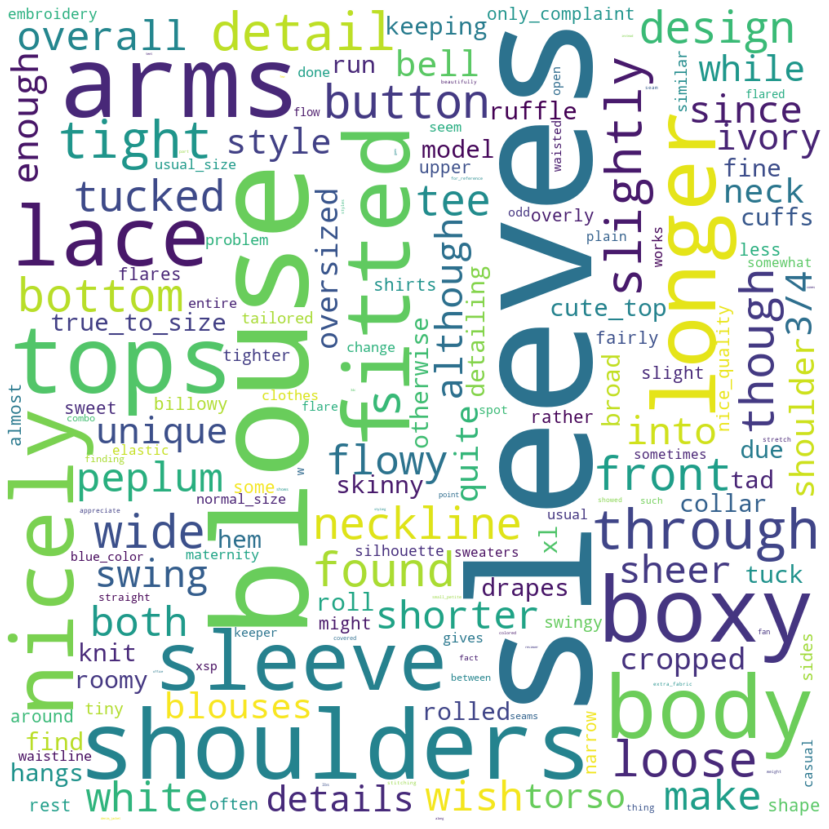

In [238]:
plt.figure(figsize=(15, 15))
freqs = dict(mdl.get_topic_words(9, 500))  # top 500 words in the topic 9
wc = WordCloud(
    width=1000, height=1000, background_color="white"
).generate_from_frequencies(freqs)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In this first topic, we can see that the most occuring words are related to the fit of the clothing shoulders, blouse, sleeve, boxy, tops, and fitted. 

#### 6. Save topics

Generate a nice table for each topic, and save it as a CSV. 

In [244]:
topics = pd.DataFrame(
    {"words": [" ".join(map(first, mdl.get_topic_words(k))) for k in range(mdl.k)]}
)

In [241]:
topics.to_csv("clothing-topics.csv", index=False)

#### 7. Add labels 

In this section, I will manually open the topics file `clothing-topics.csv` to add labels to each topic.

Read the editted `clothing-topics.csv` to read all labels of each topic. 

In [259]:
topics = pd.read_csv("clothing-topics.csv")

In [260]:
topics["label"]

0            quality
1     size reference
2            bottoms
3       disappointed
4     size reference
5     size reference
6        complements
7         outerwears
8        complements
9               tops
10           quality
11      as described
12             tight
13             thin 
14           bottoms
15             tight
16    size reference
17         recommend
18           quality
19           quality
20             color
21       complements
22         recommend
23       complements
24              thin
Name: label, dtype: object

Try to get topic for the first review 

In [261]:
df['review_text'].iloc[1]

'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [256]:
mdl.docs[0].get_topics()

[(8, 0.3597940504550934),
 (19, 0.12696652114391327),
 (0, 0.0427306592464447),
 (3, 0.03880885988473892),
 (21, 0.03319813683629036),
 (14, 0.02886774390935898),
 (10, 0.027776656672358513),
 (13, 0.026485323905944824),
 (17, 0.026102488860487938),
 (20, 0.02542833425104618)]

Select a first few topic only with the highest frequency. 

In [262]:
[t for t, w in mdl.docs[0].get_topics() if w > 0.04]

[8, 19, 0]

In [263]:
[topics['label'].loc[t] for t, w in mdl.docs[0].get_topics() if w > 0.04]

['complements', 'quality', 'quality']

The top 2 labels for this reviews are complements and the quality of the clothes. The first sentence of the reviews has "Love this dress!" which indicate that is a complement. In addition, the review talks about the length and true midi, and truly petite which is about the quality of the dress. 

#### 8. Find labels for all reviews  

In [264]:
label_df = []
for i in range(len(df)):
    label_df.append([topics['label'].loc[t] for t, w in mdl.docs[i].get_topics() if w > 0.04])

In [265]:
label_df = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, label_df) for i in b]

#### 9. Review labels of all reviews

Count the number of reviews that have each label. 

In [266]:
Counter(label_df)

Counter({'complements': 24937,
         'quality': 23085,
         'size reference': 17336,
         'color': 5816,
         'as described': 4997,
         'recommend': 10010,
         'disappointed': 9464,
         'outerwears': 3743,
         'bottoms': 9755,
         'thin': 4123,
         'tight': 8839,
         'thin ': 6008,
         'tops': 4707})

Most reviews complement the items that they bought, which makes sense because most reviews have 5-star rating. In addition, the quality of the clothes, size reference, and recommendation are also very popular labels in the reviews. The least common labels are about tops, how thin the clothes are, and outerwears. 

Now that we have labels for the topic. We can use the labels to help the business owner look at the reviews faster. They can focus on the review labels and know which would be best to improve their business. 

In addition, we can create a classifier model to identify if the review is a bad review or good review. 

### Classifier Model to Predict Type of Reviews - Model Selection  

Since there are 5 levels of rating factors of integers 1 to 5, with 1 being the worse and 5 being the best. We can assign bucket for the ratings: 
- Good: 5-star rating
- So-so: 3 to 4-star rating 
- Bad: 1 to 2-star rating 

In this section, we will try various of different models to select the one that would generate the best F1 scores. 

#### 1. Data Processing

Create a new column called `rating_type` to have three factors good/so-so/bad reviews based on `rating` columns with 1 to 5 star reviews. 

In [32]:
df_type = df.copy()

In [33]:
m = df_type['rating'].isin([1, 2])
df_type['rating'] = df_type['rating'].mask(m, 'Bad')

In [34]:
m = df_type['rating'].isin([3, 4])
df_type['rating'] = df_type['rating'].mask(m, 'So-so')

In [35]:
m = df_type['rating'].isin([5])
df_type['rating'] = df_type['rating'].mask(m, 'Good')

Count the values of each bucket. 

In [36]:
df_type["rating"].value_counts()

Good     12535
So-so     7728
Bad       2370
Name: rating, dtype: int64

Most of the reviews are in a Good bucket. On the other hand, the least amount of reviews are from the Bad bucket. Now we have to split the data into training and testing set. With a hold-out test set, we can validate the model after training it with the training set. 

#### 2. Train/Test Split 

To split the train/test set, we use a random proportion of .75/.25. In the words, the training data will be randomly select 75% of the data. 

In [37]:
train, test = train_test_split(df_type, test_size = 0.25, random_state = 1233)

In [18]:
len(train)

16974

In [19]:
len(test)

5659

#### 3. Generate Baseline Dummary Classifier

In this section, we will generate a dummy classifier to predict rating group. First, create 5-fold cross validation resampling.  

In [294]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5432) 

In [296]:
# create baseline using Dummy classifier function 
baseline = DummyClassifier()
# see cross validation score/accuracy
cross_val_score(baseline, train["tokens"], train["rating"], cv = cv)

array([0.55346097, 0.55375552, 0.55375552, 0.55346097, 0.55362404])

In [297]:
predicted = cross_val_predict(baseline, train["tokens"], train["rating"], cv = cv)
print(classification_report(train["rating"], predicted))

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Bad       0.00      0.00      0.00      1766
        Good       0.55      1.00      0.71      9397
       So-so       0.00      0.00      0.00      5811

    accuracy                           0.55     16974
   macro avg       0.18      0.33      0.24     16974
weighted avg       0.31      0.55      0.39     16974



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Using a basic dummy classifier, the model has really low F1 score for accuracy and macro average. The accuracy score is .55 which is nearly random guessing. We need a better model for the classifier. 

#### 4. Bernoulli Naive Bayes Model 

Set up pipeline for Bernoulli Naive Bayes

In [300]:
bnb = make_pipeline(CountVectorizer(analyzer=identity), BernoulliNB())

Generate prediction and report for this model: 

In [301]:
predicted = cross_val_predict(bnb, train["tokens"], train["rating"], cv = cv, n_jobs = -1)
print(classification_report(train["rating"], predicted))

              precision    recall  f1-score   support

         Bad       0.67      0.21      0.32      1766
        Good       0.76      0.82      0.79      9397
       So-so       0.56      0.60      0.58      5811

    accuracy                           0.68     16974
   macro avg       0.66      0.55      0.56     16974
weighted avg       0.68      0.68      0.67     16974



The accuracy score for this model increases from .55 (dummy baseline model) to .68. Which is a good initial start to select model. The macro average doubled from Bernoulli Naive Bayes compared to baseline dummy model. 

#### 5. Multinomial Naive Bayes

Set up pipeline and 5-fold cross validation for Multinomial Naive Bayes. For 5-fold cross validation, we can use the same `cv` as specified before. 

In [305]:
mnb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())

Predict rating group using Multinomial Naive Bayes model. 

In [306]:
predicted = cross_val_predict(mnb, train["tokens"], train["rating"], cv = cv, n_jobs = -1)
print(classification_report(train["rating"], predicted))

              precision    recall  f1-score   support

         Bad       0.67      0.29      0.41      1766
        Good       0.81      0.84      0.82      9397
       So-so       0.59      0.65      0.62      5811

    accuracy                           0.72     16974
   macro avg       0.69      0.60      0.62     16974
weighted avg       0.72      0.72      0.71     16974



The Multinomial Naive Bayes method definate brings the F1 scores of accuracy and macro average up. These scores are above .60 now. However, we would still want our scores to be higher. We can try more methods of classifiers and linear models.  

#### 6. SGD Classifier

Create pipeline for SGD Classifier and generate prediction to see a summary of this model. 

In [308]:
sgd = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
sgd.fit(train["tokens"], train["rating"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["rating"], predicted))

              precision    recall  f1-score   support

         Bad       0.60      0.36      0.45       604
        Good       0.77      0.82      0.79      3138
       So-so       0.56      0.58      0.57      1917

    accuracy                           0.69      5659
   macro avg       0.64      0.58      0.60      5659
weighted avg       0.68      0.69      0.68      5659



Unfortunately, using this model SGD Classifier, we are not able to get higher F1 scores than Multinomial Naive Bayes model. 

#### 7. Tfidf Transformer

Create pipeline for Tfidf Transformer model, generate prediction and compare. 

In [309]:
sgd_t = make_pipeline(CountVectorizer(analyzer=identity), TfidfTransformer(), SGDClassifier())
sgd_t.fit(train["tokens"], train["rating"])
predicted_t = sgd_t.predict(test["tokens"])
print(classification_report(test["rating"], predicted_t))

              precision    recall  f1-score   support

         Bad       0.69      0.35      0.46       604
        Good       0.77      0.89      0.83      3138
       So-so       0.62      0.56      0.59      1917

    accuracy                           0.72      5659
   macro avg       0.69      0.60      0.63      5659
weighted avg       0.71      0.72      0.71      5659



This model has the same accuracy and weighted average F1 scores with Multinomial Naive Bayes classifier. However, this model has a higher macro average F1 score by .01. 

#### 8. Truncated SVD

Create pipeline for truncated SVD, generate prediction, and compare with other models. 

In [312]:
svd = make_pipeline(CountVectorizer(analyzer = identity), 
                    TfidfTransformer(), 
                    TruncatedSVD(n_components = 100),
                    SGDClassifier())

svd.fit(train["tokens"], train["rating"])
predicted_svd = svd.predict(test["tokens"])
print(classification_report(test["rating"], predicted_svd))

              precision    recall  f1-score   support

         Bad       0.74      0.05      0.09       604
        Good       0.74      0.87      0.80      3138
       So-so       0.56      0.55      0.56      1917

    accuracy                           0.68      5659
   macro avg       0.68      0.49      0.48      5659
weighted avg       0.68      0.68      0.64      5659



Unfortunately, this model truncated SVD wouldn't give us higher F1 scores compared to Tfidf tranformer or Multinomial Naive Bayes. This model F1 scores are a little bit before .70 for accuracy, macro average, and weighted average values. 

After evaluating all the models, here are some take away from the model selection process: 
- Multinomial Naive Bayes and Tfidf Transformer have the highest F1 scores 
- Dummy classifier has the lowest F1 scores
- Since Tfidf Transformer has a higher macro average compared to Multinomial Naive Bayes, we will pick Tfidf to be our final model 
- The final model will have hyperparameter search process to see if we can get higher F1 scores, preferably above .80 for accuracy score. 

### Hyperparameter Search

In this section, we will do hyperparameter search to tune each parameters of the Tfidf Transformer Classifier. This will give us the best parameters for the classifier and will give us higher accuracy scores, hopefully. 

#### 1. Define Baseline Model

In [319]:
simplefilter(action = "ignore", category = FutureWarning)

In [320]:
mlflow.set_experiment("project-3")
sgd = make_pipeline(
    CountVectorizer(analyzer=identity), TfidfTransformer(), SGDClassifier()
)

INFO: 'project-3' does not exist. Creating a new experiment


Define based model first. Our base model would be model specified in section 7, Tfidf Transformer. 

In [354]:
sgd_base = make_pipeline(CountVectorizer(analyzer=identity), TfidfTransformer(), SGDClassifier())
sgd_base.fit(train["tokens"], train["rating"])
predicted_base = sgd_base.predict(test["tokens"])
print(classification_report(test["rating"], predicted_base))

              precision    recall  f1-score   support

         Bad       0.70      0.34      0.46       604
        Good       0.77      0.88      0.83      3138
       So-so       0.62      0.58      0.60      1917

    accuracy                           0.72      5659
   macro avg       0.70      0.60      0.63      5659
weighted avg       0.71      0.72      0.71      5659



#### 2. Generate Optimzied Model

Start hyperparameter tunning and log scores to MFlow

In [322]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "tfidftransformer__use_idf": [True, False],
        "sgdclassifier__alpha": loguniform(1e-6, 1e-2),
    },
    n_iter = 25,
    scoring = "f1_macro",
)
search.fit(train["tokens"], train["rating"])
log_search(search)

CPU times: user 1.77 s, sys: 222 ms, total: 1.99 s
Wall time: 31.8 s


In [323]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "tfidftransformer__use_idf": [True, False],
        "sgdclassifier__alpha": loguniform(1e-8, 100),
    },
    n_iter=25,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["rating"])
log_search(search)

CPU times: user 1.94 s, sys: 231 ms, total: 2.17 s
Wall time: 30.6 s


In [324]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "tfidftransformer__use_idf": [True, False],
        "sgdclassifier__alpha": [0.1],
    },
    n_iter=25,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["rating"])
log_search(search)

CPU times: user 1.83 s, sys: 145 ms, total: 1.97 s
Wall time: 24.8 s


In [327]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(-1, 1),
        "countvectorizer__max_df": uniform(.01, 0.05),
        "tfidftransformer__use_idf": [True, False],
        "sgdclassifier__alpha": [0.1],
    },
    n_iter=50,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["rating"])
log_search(search)

CPU times: user 2.8 s, sys: 317 ms, total: 3.11 s
Wall time: 52.5 s


Based on hyperparameter search, the best parameters would be: 
- Min df: 2
- Max df: 1.96 
- Use IDF: False 
- Alpha: 7e-06 

With these parameters, the model will give mean test scores of .62. 

Generate the model with new parameters generated from hyperparameter process. 

In [353]:
sgd = make_pipeline(
    CountVectorizer(analyzer = identity, 
                    min_df = 2, 
                    max_df = 1.96),
    TfidfTransformer(use_idf = False),
    SGDClassifier(alpha = 7e-06),
)
sgd.fit(train["tokens"], train["rating"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["rating"], predicted))

              precision    recall  f1-score   support

         Bad       0.63      0.42      0.50       604
        Good       0.79      0.84      0.82      3138
       So-so       0.60      0.60      0.60      1917

    accuracy                           0.71      5659
   macro avg       0.67      0.62      0.64      5659
weighted avg       0.71      0.71      0.71      5659



After the hyperparameter search, the optimzied model seems to have similar F1 scores compared to the baseline model. To futher confirm this, we would want to do some tests. 

In [362]:
# compare if two classifier give different answers
# counting how many right/wrong
diff = (predicted == test["rating"]).astype(int) - (predicted_base == test["rating"]).astype(int)
sum(diff == 1), sum(diff == -1), sum(diff == 0)

(168, 212, 5279)

In [363]:
stats.binom_test([sum(diff == 1), sum(diff == -1)], alternative = "greater")

0.989573980860203

In [364]:
stats.wilcoxon(diff, alternative="greater")

WilcoxonResult(statistic=32004.0, pvalue=0.9880007224218706)

Binomial and Wilcoxon test have really high p-values. This indicates that the two models (basedline and optimized) would generate the same information. The two models are not different. 

#### 3. Save model 

Save the model to use later. 

In [368]:
cloudpickle.dump(sgd, open("sgd.model", "wb"))

#### 4. Imrpove F1 Score

In [38]:
# read model 
# read model 
sgd = cloudpickle.load(open("sgd.model", "rb"))

In [39]:
sgd.fit(train["tokens"], train["rating"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["rating"], predicted))

              precision    recall  f1-score   support

         Bad       0.64      0.40      0.49       604
        Good       0.75      0.90      0.82      3138
       So-so       0.62      0.50      0.55      1917

    accuracy                           0.71      5659
   macro avg       0.67      0.60      0.62      5659
weighted avg       0.70      0.71      0.69      5659



In [372]:
scores = sgd.decision_function(test["review_text"])

In [373]:
scores[0,:]

array([-1.53478049,  0.58883949, -1.25714013])

In [374]:
highest = scores.max(axis=1)

Select margin for subset

In [382]:
margin = scores[:,2] 

In [383]:
margin.max(), margin.min()

(0.20864925850786742, -2.3112679907419427)

For F1 score of 1.00, we can use margin > .2 which is the maximum of the margin. But we don't want the accuracy score to be perfect 1.00. 

In [390]:
print(classification_report(test["rating"][margin > .2], predicted[margin > .2]))

              precision    recall  f1-score   support

       So-so       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [425]:
s = -0.219
print(classification_report(test["rating"][margin > s], predicted[margin > s]))

              precision    recall  f1-score   support

         Bad       0.75      0.75      0.75         4
        Good       1.00      0.70      0.82        10
       So-so       0.67      0.89      0.76         9

    accuracy                           0.78        23
   macro avg       0.81      0.78      0.78        23
weighted avg       0.83      0.78      0.79        23



By selecting margin greater than -0.219, we can get an accuracy F1 score of .78, macro average of .78, and weighted average of .79. This model is very so far with the margin.

So far, this has been the best model compared to the baseline and optimized model of Tfidf Transformer model.

### Error Analysis

In this section, we will evaluate the model and classify the errors/limitation of this model. 

Find how many cases have empirical rating as Good but predicted score is not Good.

#### 1. Misclassification

In [46]:
err = test[(test['rating'] == 'Good') & (predicted == 'Bad')]
len(err)

16

There are 16 good reviews that are misclassified as bad review. We can see the review text to see why.  

In [47]:
err['review_text'].iloc[0]

'A nice rayon peasant shirt - like the sleeve length. good for a fuller figure, covers all the bad sports and very comfortable.'

This sample review is a good review, but is classified as a bad review. This makes sense for the model to classifiy this review as bad because in the sentence, we can see there are some negative words like peasant shirt, fuller figure, and bad sports. This could mean the writer saying the shirt is very pleasant for her, or the shirt is more for fuller figure.   

We can look at some example of bad reviews that were classified as good.  

In [48]:
err = test[(test['rating'] == 'Bad') & (predicted == 'Good')]
len(err)

91

In [51]:
err['review_text'].iloc[0]

'After reading every review, i was certain i knew exactly what i was getting with this dress. wrong. i sized up from a small to a medium and the dress was still uncomfortably tight on my rib cage. the top is very exposing of the bust, and i\'m small busted. i can\'t stand wearing camis, so there no way i\'d be able to wear this dress even if i sized up again to a large. for reference, i\'m 5\'6", a straight build 134 lbs, and wear a 6. pluses on this dress are, i loved the green color and length of sk'

In [52]:
err['review_text'].iloc[1]

"I usually buy a pair of these kind of pants every year from this brand. they are lightweight, sturdy and very flattering to my curvier body. this brand can run big, so i usually buy a size 2 rather than my normal size 4. i was going to wait it out and let someone else try them first, but then i caved and ordered them in two sizes: 26 and 27 because they didn't label them 2, 4, 6 etc. anymore. these pants still look well made and have cute little details, but they are bigger than ever!! the 27's"

Most misclassification to good review talk about size of the outfit. These two samples are clearly sound like bad review because the size are not the right size foor the customers. But the sizing confused the model to predict these bad review as good reviews.

#### 2. Confusion Matrix 

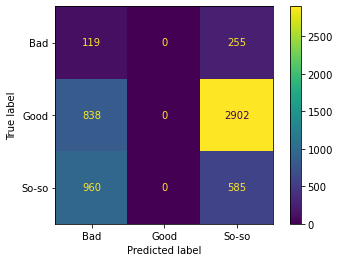

In [57]:
plot_confusion_matrix(sgd, test['rating'], predicted)

Most misclassification are from Good review and So-so reviews.

### Summary of Analysis 

1. Some common terms for the reviews would help customers and employee save their time. For example, if a customers see the most common terms for a shirt is "true to size" or "perfect", then they would more likely to buy that shirt with confident. However, if they see terms like "thin" and "bad quality", they would not buy the shirt. Instead of reading long paragraphs of reviews, they can just see the top few words that associate with the shirt. Similar with customers, employers also gets a lot of benefits from keywords. They would save a lot of their resources to read all the reviews manually. With the keywords, they can decide to discontinues or order more products. 

2. Since there are about 23 thousands reviews for an E-commerce clothing company, it could takes a lot of employees to read all the reviews manually. Therefore, the first section of the model's purpose is to generate topics for each each reviews. Reading a few summarized words of the review would help employees save a lot of their time. The first model was able to generate 25 groups of topics with 13 lables including:

- quality
- size reference
- bottoms
- disappointed
- complements
- outerwears
- tops
- as described
- tight
- thin 
- bottoms
- recommend
- color

3. A model was able to develop to classifify the review as either a good/so-so/bad review. This will help the customer/employers to filter the review based on the classifications. Here are the information and result of the model:

- Classification type: SGD with Tfidi tranformaer 
- Min df: 2
- Max df: 1.96
- Use IDF: False
- Alpha: 7e-06
- F1 accuracy score: .78 
- F1 macro average: .78 
- Weighted average: .79

See `Final project report.pdf` for a complete report. 